# Assignment 3: Classification – part 1

Using the training and validation data subsets (from assignment 2), you are required to train the classification models, evaluate the classification models, and report the classification performance as per the classification evaluation method. You are required to perform the below tasks:

# Task 1. Prepare the data

• Include all the required code from assignments 1 and 2 and apply any changes that you think are necessary.

• Explain what changes you made to the code from assignment 1, and what was the purpose of these changes, if any.

In [67]:
# Load the Drive helper and mount

import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/HINF6210/data/Dataset_Jack.csv"

np.random.seed(0) # set seed now since we are randomizing with splitting

data = pd.read_csv(path, na_values='?') # specify that ? are missing  

# clean names
data.columns=data.columns.str.lower().str.replace(' ','_')

data = data.replace({'t': True, 'f': False, 'M': True, 'F': False}) 
# turn strings into a boolean
# male = T, female = F, doing this to maintain any missing values 

# rename because we turned sex into a boolean
data = data.rename(columns={"sex": "sex_male"}) # more informative name

# dummy code referral_source
data = pd.get_dummies(data, columns = ['referral_source'])
# apply name cleaning again
data.columns=data.columns.str.lower().str.replace(' ','_')

# convert columns to appropriate data type
data=data.convert_dtypes()

# replace pandas NAs with numpy NaNs
data = data.replace(pd.NA, np.nan)

# clean and create target
data[['target','class_number']] = data['class'].str.split(".", expand=True)
data['class_number'] = data['class_number'].str.replace('|','')
# code target to 1/0
data['target'] = np.where(data['target'] == "negative", 0, 1)
# convert target to boolean
data=data.convert_dtypes()

# remove some uneeded columns
data=data.drop(['class', 'class_number', 'tbg', 'tbg_measured'], axis = 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [68]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# performing MICE imputation, with hyperparameter values based on assignment 2
my_imputer = IterativeImputer(
  missing_values=np.nan, # specify missing here to make sure we use np NaNs
  random_state=0, # keep random number generator as 0 (there was a typo from assignment 2 that set it as 3)
  n_nearest_features=3, # due to analysis from assignment 2
  max_iter=2, # changed from 1 to 2 based on the analysis from assignment 2
  sample_posterior=True, # need to set to true for this iterative imputer to work
)

imputed_data = pd.DataFrame(
  my_imputer.fit_transform(data), # impute
  columns = data.columns # specify column names as it returns numbers
)

# fixing datatypes
imputed_data=imputed_data.convert_dtypes()
imputed_data['target'] = imputed_data['target'].astype(bool) # so that kfold strat will work
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3076 non-null   Float64
 1   sex_male                   3076 non-null   Float64
 2   on_thyroxine               3076 non-null   Int64  
 3   query_on_thyroxine         3076 non-null   Int64  
 4   on_antithyroid_medication  3076 non-null   Int64  
 5   sick                       3076 non-null   Int64  
 6   pregnant                   3076 non-null   Int64  
 7   thyroid_surgery            3076 non-null   Int64  
 8   i131_treatment             3076 non-null   Int64  
 9   query_hypothyroid          3076 non-null   Int64  
 10  query_hyperthyroid         3076 non-null   Int64  
 11  lithium                    3076 non-null   Int64  
 12  goitre                     3076 non-null   Int64  
 13  tumor                      3076 non-null   Int64

## Split data

In [69]:
from sklearn.model_selection import train_test_split

y = imputed_data.loc[:, 'target'] # target
x = imputed_data.drop(['target'], axis=1) # features (drop target only)

# do an 80/20 split
x_train, x_test, y_train, y_test = train_test_split(
  x,
  y, 
  train_size=0.8, 
  test_size=None,
  random_state=10,
  shuffle=True,
  stratify=y # to retain similar proportions in the samples
)

# Task 2. Nearest Neighbors Classifier

• Train and test a KNeighborsClassifier from the neighbors module of scikit-learn (link).

• Leave the hyperparameters to their default values.

• Use the most suitable scoring metric(s) (link) for your dataset.

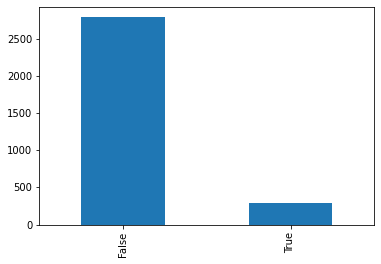

In [70]:
import matplotlib.pyplot as plt

imputed_data['target'].value_counts().plot(kind='bar');

Our target is very imbalanced, so we should not use accuracy as an evaluation metric for classifiers. There are a couple of useful metrics for imbalanced data including: 

* AUC
* Cohen's Kappa
* F1 Score
* Jaccard Score

So we'll try all of these to see how our classifier does:

## Classify 3 models

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict
from decimal import Decimal
from sklearn.metrics import (
    cohen_kappa_score,
    f1_score,
    roc_auc_score,
    jaccard_score,
    accuracy_score # include accuracy (for fun)
)

# leaving all hyper parameters default here
knn = KNeighborsClassifier()
gnb = GaussianNB()
dt = DecisionTreeClassifier()

clf_list = [
    (knn, "knn"),
    (gnb, "naivebayes"),
    (dt, "decisiontree")
]

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(x_train, y_train)
    y_prob_train = clf.predict_proba(x_train)
    y_pred_train = clf.predict(x_train)

    y_prob = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)
    scores["classifier"].append(name)

    for metric in [cohen_kappa_score, f1_score, roc_auc_score, jaccard_score, accuracy_score]:
        score_name = metric.__name__.replace("score", "train")
        scores[score_name].append(metric(y_train, y_pred_train))

    for metric in [cohen_kappa_score, f1_score, roc_auc_score, jaccard_score, accuracy_score]:
        score_name = metric.__name__.replace("score", "test")
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("classifier")
    score_df = score_df.round(3)

score_df

,cohen_kappa_train,f1_train,roc_auc_train,jaccard_train,accuracy_train,cohen_kappa_test,f1_test,roc_auc_test,jaccard_test,accuracy_test
classifier,,,,,,,,,,
knn,0.671,0.697,0.791,0.535,0.951,0.529,0.558,0.703,0.387,0.938
naivebayes,0.054,0.214,0.613,0.120,0.317,0.048,0.208,0.601,0.116,0.320
decisiontree,1.000,1.000,1.000,1.000,1.000,0.971,0.973,0.974,0.948,0.995


We can see that accuracy is suspiciously good.

I've also showed the metrics for the classifiers in task 3 and 4 here as to prevent repetitive code (and to easily compare evaluation metrics across classifiers).

#Task 3. Naïve Bayes Classifier
• Train and test a GaussianNB from the naive_bayes module of scikit-learn (link).

• Leave the hyperparameters to their default values.

• Use the most suitable scoring metric(s) (link) for your dataset.

• Show the probability of each class from the trained classifier.

Since I already trained and tested the `GaussianNB` in task 2, I'll show the probabilities here.

In [96]:
gnb = GaussianNB()
print(gnb.fit(x_train, y_train).classes_) # shows the classes in order
# use predict_proba to get the raw probablities of each row in our training set
probas_train = gnb.fit(x_train, y_train).predict_proba(x_train)
probas_test = gnb.fit(x_test, y_test).predict_proba(x_test)

# false = negative
pd.DataFrame({'False Prob': probas_train[:, 0], 'True Prob': probas_train[:, 1]})


[False  True]


,False Prob,True Prob
0,5.287239e-09,1.0
1,1.692682e-07,1.0
2,7.123882e-09,1.0
3,2.024061e-09,1.0
4,3.470534e-07,1.0
...,...,...
2455,2.277968e-09,1.0
2456,1.626726e-09,1.0
2457,1.000000e+00,0.0
2458,2.679150e-10,1.0


In [97]:
# for testing set
pd.DataFrame({'False Prob': probas_test[:, 0], 'True Prob': probas_test[:, 1]})

,False Prob,True Prob
0,6.666021e-14,1.0
1,7.291511e-19,1.0
2,1.246270e-15,1.0
3,4.403581e-10,1.0
4,4.641624e-13,1.0
...,...,...
611,7.459018e-17,1.0
612,6.800939e-18,1.0
613,4.251844e-14,1.0
614,1.000000e+00,0.0


## Plot of probabilities

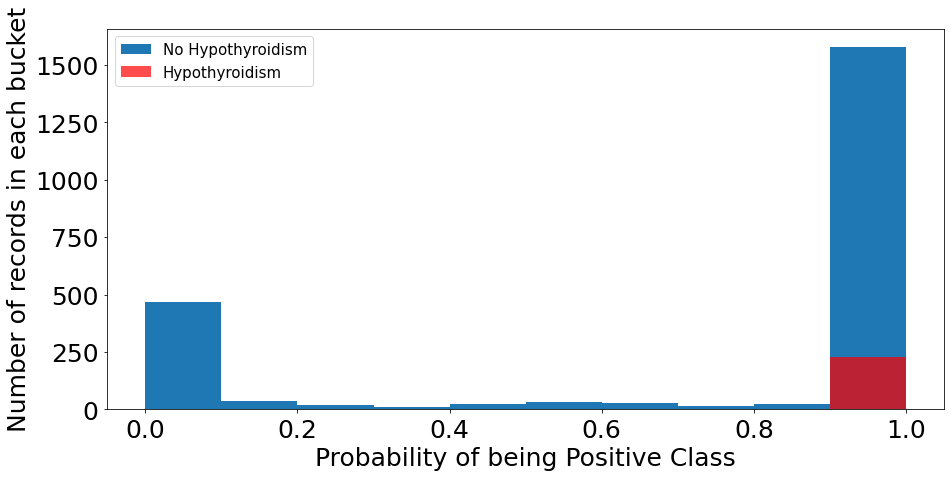

In [92]:
prediction=gnb.fit(x_train, y_train).predict_proba(x_train)[:,1]
plt.figure(figsize=(15,7))
plt.hist(prediction[y_train==False], bins=10, label='No Hypothyroidism')
plt.hist(prediction[y_train==True], bins=10, label='Hypothyroidism', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

These predictions looks pretty bad... It's estimating far too many negatives as having high probabilities.

However, from the sklearn [documentation](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes), it says that probability estimations from `predict_proba` is "not to be taken too seriously" because it is "known to be a bad estimator". So we probably shouldn't think much of these probabilities.

# Task 4. Decision Tree Classifier

• Train and test a DecisionTreeClassifier from the tree module of scikit-learn (link).

• Leave the hyperparameters to their default values.

• Use the most suitable scoring metric(s) (link) for your dataset.

• Identify the specific decision tree algorithm used by this classifier, and comment on the main difference between this algorithm and other decision tree algorithms.

• Visualize the decision tree using the dedicated function in the tree module of scikit-learn.

Explain what the gini values in the nodes of the tree mean.

## sklearn DecisionTreeClassifier?

From the documentation: "scikit-learn uses an optimized version of the CART algorithm". CART stands for "Classification and Regression Trees", where the feature and threshold that produce the most information gain at each node are used to build binary decision trees. The main differece in CART is that it supports numerical target variables (a regression problem) and doesn't make rules.

There are several other algorithms, including ID3 (iterative dichotomiser), and successors C4.5 and C5.0.
* ID3: The technique builds a multiway tree by greedily identifying the variable that will yield the largest information gain for each node. Features here need to be categnorical.
* C4.5 removes the categorical variable-only restriction. This algorithm converts ID3 outputs into rules which will be evaluated to determine the order of application.
* C5.0 is a propriety version which use less memory, is more accurate, and creates smaller splitting rules.

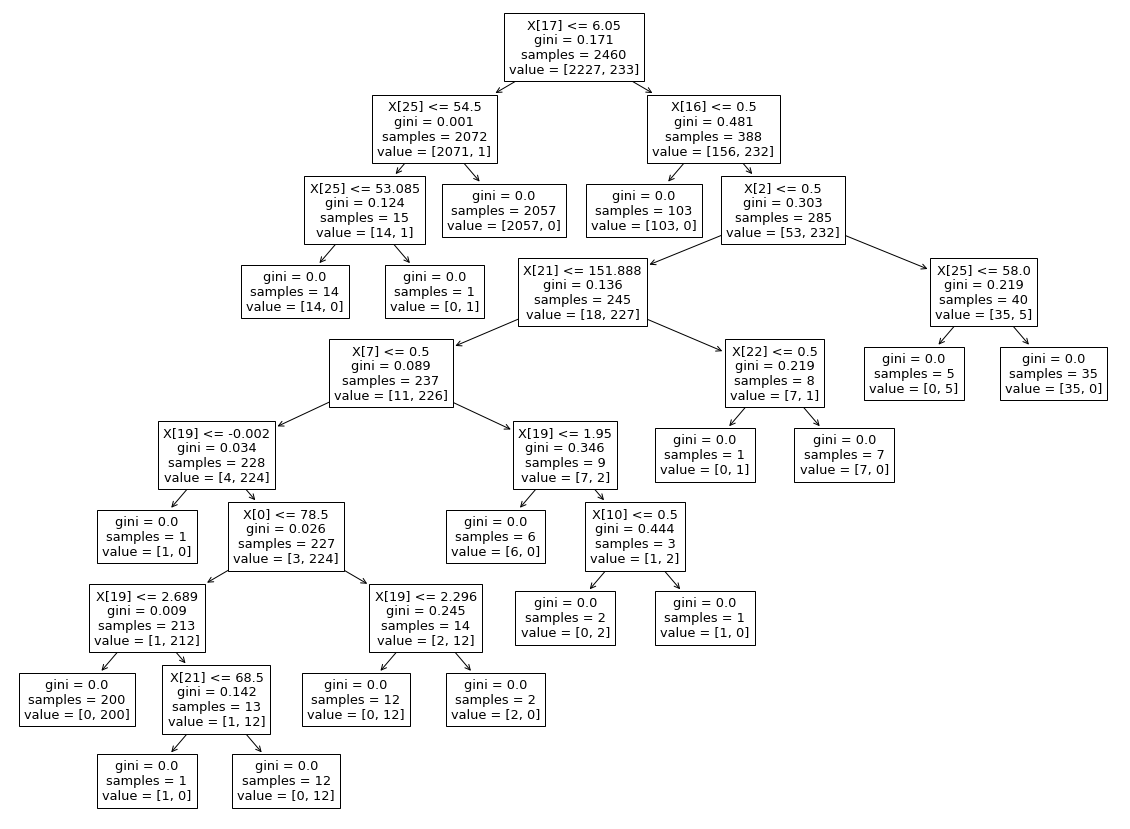

In [74]:
from sklearn import tree

dt = dt.fit(x_train, y_train) # defined from task 2

plt.figure(figsize=(20,15))
tree.plot_tree(dt);

The gini value is a score that quantifies the 'purity' of a node in the tree. The gini values can range from 0 to 0.5, with a score of 0 meaning that the node is pure (only a single class exists in that node). As we can see in the tree figure above, the algorithm does not attempt to make more splits in the tree where the gini value is 0 as there is only 1 class and no further splits can be made on the class.

When we have a gini value of greater than 0, we know that the samples within that node belong to different classes and can be split.

#Task 5. Overfitting and underfitting

• For the classifiers developed in this assignment, measure which of the classifiers tend to overfit more and which tend to underfit more and explain your findings.
* This [link](https://machinelearningmastery.com/overfitting-machine-learning-models/) was helpful

In [75]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys()) # view the possible scores in learning_curves

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

I will use learning curves to do this.

A common pattern for overfitting can be seen on learning curve plots when:
* Model performance on the training dataset continues to improve (e.g. loss or error continues to fall or accuracy continues to rise)
* Performance on the test set improves to a point and then begins to get worse.





## f1 learning curve

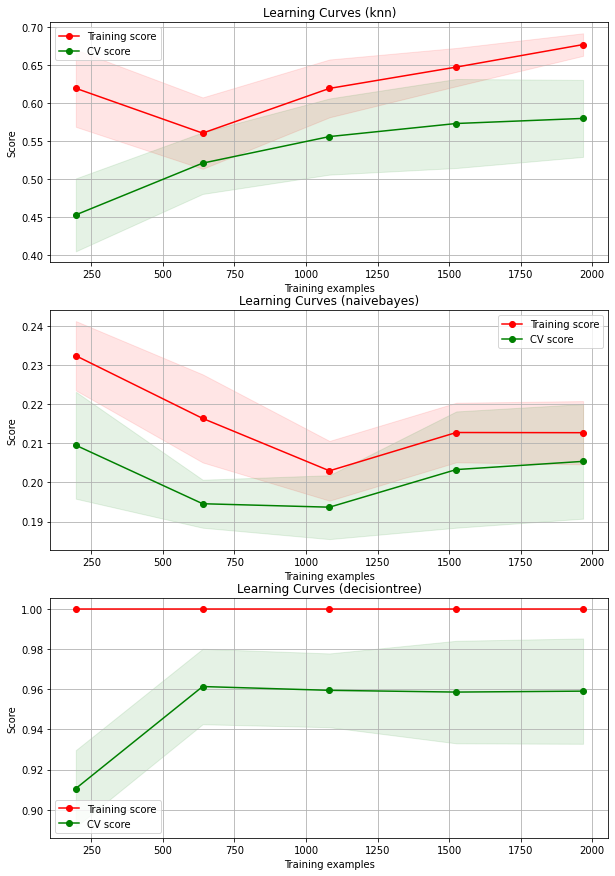

In [76]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs = axs.flatten()

# specifying to use stratified k fold
# although it's already the default so don't actually need to 
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scoring_methods = [
    'f1',
    'jaccard',
    'roc_auc'
]

i=0
for i, (clf, name) in enumerate(clf_list):
  ax = axs[i]
  
  ax.set_title('Learning Curves (%s)' % name)
  ax.set_xlabel("Training examples")
  ax.set_ylabel("Score")
  
  train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                          x_train, 
                                                          y_train, 
                                                          cv=skf,
                                                          scoring='f1',
                                                          random_state=0)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax.grid(True)
  ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color="r")
  ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color="g")
  ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
           label="Training score")
  ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
           label="CV score")
  ax.legend(loc="best")
  i+=1
plt.show()

## jaccard learning curve

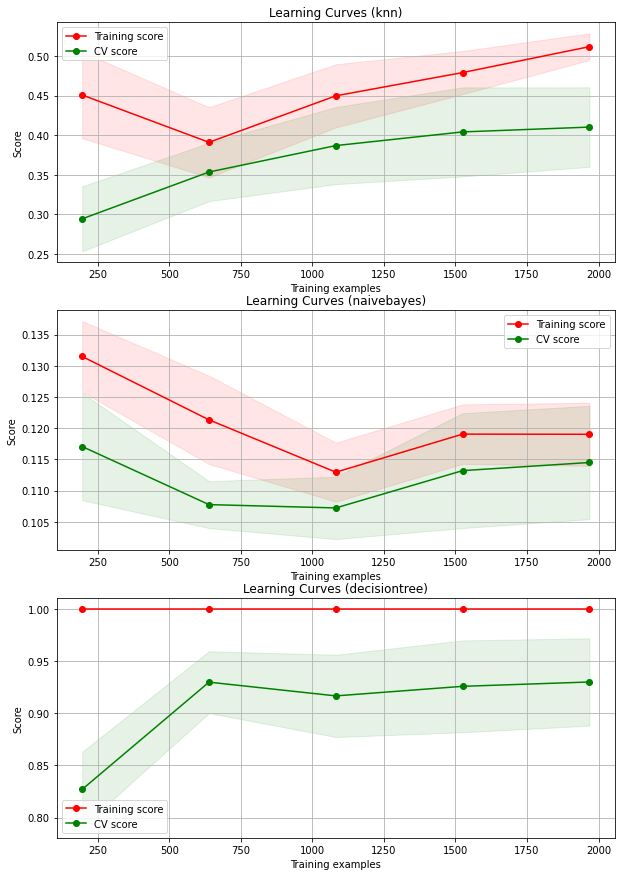

In [77]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs = axs.flatten()

i=0
for i, (clf, name) in enumerate(clf_list):
  ax = axs[i]
  
  ax.set_title('Learning Curves (%s)' % name)
  ax.set_xlabel("Training examples")
  ax.set_ylabel("Score")
  
  train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                          x_train, 
                                                          y_train, 
                                                          cv=skf,
                                                          scoring='jaccard',
                                                          random_state=0)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax.grid(True)
  ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color="r")
  ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color="g")
  ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
           label="Training score")
  ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
           label="CV score")
  ax.legend(loc="best")
  i+=1
plt.show()

## roc auc learning curve

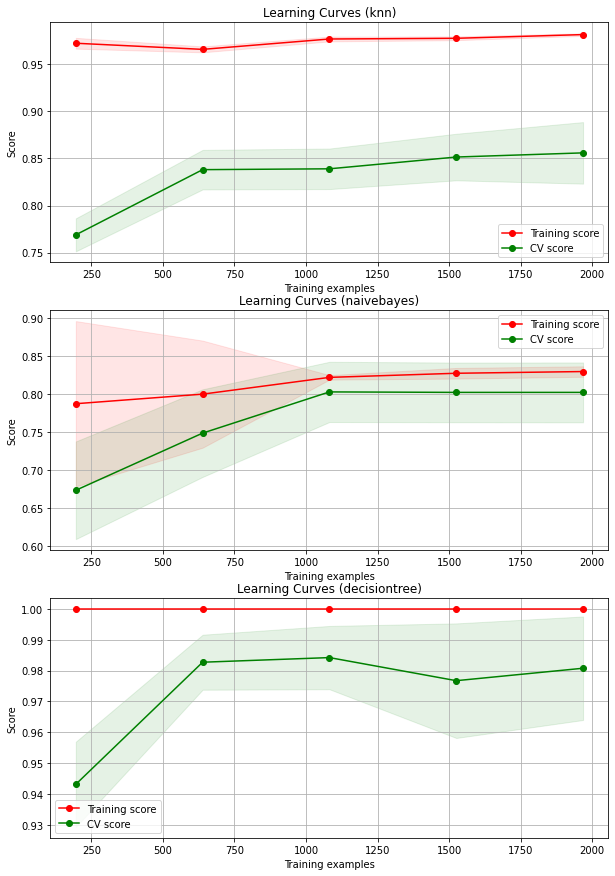

In [78]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs = axs.flatten()

i=0
for i, (clf, name) in enumerate(clf_list):
  ax = axs[i]
  
  ax.set_title('Learning Curves (%s)' % name)
  ax.set_xlabel("Training examples")
  ax.set_ylabel("Score")
  
  train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                          x_train, 
                                                          y_train, 
                                                          cv=skf,
                                                          scoring='roc_auc',
                                                          random_state=0)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  ax.grid(True)
  ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color="r")
  ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color="g")
  ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
           label="Training score")
  ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
           label="CV score")
  ax.legend(loc="best")
  i+=1
plt.show()

Based on the learning curves with 5-fold cross-validated training and test scores, the models learned on the training data tend to slightly overfit the data. 

All the evaluation metrics are consistently lower in the CV sets than the original training set. In addition, for a couple of metrics, they improve but taper off as more data is learned (e.g decision tree AUC).

It seems that the decision tree classifier consistently overfits the data across all 3 evaluation metrics.

KNN is less overfitting in this data than decision trees, but overfits more than the naive bayes classifier.

In [79]:
score_df

,cohen_kappa_train,f1_train,roc_auc_train,jaccard_train,accuracy_train,cohen_kappa_test,f1_test,roc_auc_test,jaccard_test,accuracy_test
classifier,,,,,,,,,,
knn,0.671,0.697,0.791,0.535,0.951,0.529,0.558,0.703,0.387,0.938
naivebayes,0.054,0.214,0.613,0.120,0.317,0.048,0.208,0.601,0.116,0.320
decisiontree,1.000,1.000,1.000,1.000,1.000,0.971,0.973,0.974,0.948,0.995


This is a reprint of the results from task 2. Here we can also see that our model is overfitting the training data, as the evaluation metrics are consistently lower than with the 20% test cut of the data.